# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

- This notebook produces the figures for **part 4** of the miniproject.

#### Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [3]:
# Make paths
main_dir =r'C:\Angeline\Lausannne\EPFL\Master\Neurosciences cellular circuits to mechanisms' # EDIT the path !!!!!!!

print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data') #if your folder is organized differently, just specify the full path to the .mat file

fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: C:\Angeline\Lausannne\EPFL\Master\Neurosciences cellular circuits to mechanisms


In [4]:
sweep_type = 'active touch'

pre_window = 0.1 # time before touch onset (s)
post_window = 0.3 # time after touch onset (s)
min_event_dur = 0 # minimal duration of active touch episode to be considered
min_iti = 0.2 # minimal intertrial interval (ITI) between 2 consecutive touch episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.01 # bin size for psth (s)
epoch_bounds = {'pre':[-0.05, 0],
                  'post':[0,0.1]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

In [5]:
data_df_subset = data_df[data_df['Sweep_Type']==sweep_type]

In [6]:
all_cells = np.unique(data_df_subset.Cell_ID)
print('Number of cells:', len(all_cells))

Number of cells: 134


In [7]:
verbose=0 #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells, 
          'cell_type':[], 
          # This is a template, an example with whisker protraction
          'numb_events': [],
          'wp_avg': [],
          'wp_amplitude_pre': [],
          'wp_amplitude_post': [],
          # Sub. Vm
          'vm_avg': [], 
          'vm_amplitude_pre': [],
          'vm_amplitude_post': [],
          # Firing rates
          'ap_avg':[],
          'ap_psth':[],
          'ap_fr_pre':[],
          'ap_fr_post':[]
        }
    
# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
    # Get cell type 
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values
    
    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration=0
    tot_number_ap=0
    
    # Initialize empty lists to get data for each trial/sweep
    tot_ap_thresh = []
    tot_ap_duration= []
    
    # Template
    tot_wp_events = []
    
    # Vm and AP FR
    tot_vm_events = []
    tot_ap_events = []
    
    ## For that cell, iterate over trials
    for trial in trial_list:
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
        
        # Get event times for that trial
        event_times = cell_trial_df['Sweep_WhiskingTimes'].values[0]

        if event_times is None: # skip when there are no events
            continue
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
        # Template: extract whisker angle and sampling rate of whisker video data
        whisker_angle = cell_trial_df['Sweep_WhiskerAngle'].values[0]
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0]
        
         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
        tot_number_ap += ap_params.shape[0]
        
                
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)
            
        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub
            
        # Once trial event times and data is collected, use this function to extract data aligned to event onset
        # -> check function (Function_Event_Triggered_Signal) parameters and code!
        # -> input data can be whatever, given a certain dimensions
        # -> events can be whatever
        # -> adjust sampling rate for data type (e.g. video, Vm)! 
        
        wp_event = Function_Event_Triggered_Signal(whisker_angle, sr_wp, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)


        # Missing data in original .mat file is encoded as -1, so this skips entires with missing data
        if type(wp_event) == int:
            continue
        if type(vm_event) == int:
            continue
        if type(ap_event) == int:
            continue
                 
        # Append each event-triggered vector and stack to an array 
        tot_wp_events += [wp_event]
        tot_wp_array = np.hstack(tot_wp_events)
        
        tot_vm_events+= [vm_event]
        tot_vm_array=np.hstack(tot_vm_events)
        
        tot_ap_events+= [ap_event]
        tot_ap_array=np.hstack(tot_ap_events)
        

    # Compute means only if a certain number of trials is present
    n_events = tot_wp_array.shape[1]
    if (n_events >= min_number_trials):
        result_dict['numb_events'] += [n_events] 
        
        # Calculate trial-averaged signals
        #Template: WP
        wp_avg = np.mean(tot_wp_array, 1) 
        result_dict['wp_avg'] += [wp_avg] #add for that cell
        
        vm_avg = np.mean(tot_vm_array, 1) 
        result_dict['vm_avg'] += [vm_avg]
        
        ap_avg = np.mean(tot_ap_array, 1) 
        result_dict['ap_avg'] += [ap_avg]
        
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        
        
        #for epoch in range(wp_bounds.shape[0]): 
        for epoch in epoch_bounds.keys():
            
            # Template: whisker protraction
            # Get bound of that epoch (pre/post)
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_wp))
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_wp-1))
            
            #Get mean in pre/post epoch
            if epoch=='pre':
                result_dict['wp_amplitude_pre'] += [wp_avg[bound_1:bound_2].mean(0)]
            else:
                result_dict['wp_amplitude_post'] += [wp_avg[bound_1:bound_2].mean(0)]
                
            # Vm, and AP firing rate
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))
            
            if epoch=='pre':
                result_dict['vm_amplitude_pre'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict['ap_fr_pre'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
            else:
                result_dict['vm_amplitude_post'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in Hz!
                result_dict['ap_fr_post'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]
                
                
    #If there are less trials than necessary, set to NaNs (exclude data)
    else:
        result_dict['numb_events'] += [n_events]
        
        #Template: WP
        wp_avg=np.nan*np.empty_like(wp_avg)
        result_dict['wp_avg'] += [wp_avg]
        result_dict['wp_amplitude_pre'] += [np.nan]
        result_dict['wp_amplitude_post'] += [np.nan]
        
        # VM
        vm_avg=np.nan*np.empty_like(vm_avg)
        result_dict['vm_avg'] += [vm_avg]
        result_dict['vm_amplitude_pre'] += [np.nan]
        result_dict['vm_amplitude_post'] += [np.nan]
        
        #AP firing rate
        ap_avg=np.nan*np.empty_like(ap_avg)
        result_dict['ap_avg'] += [ap_avg]
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        
        result_dict['ap_fr_pre'] += [np.nan]
        result_dict['ap_fr_post'] += [np.nan]

                         
# Convert each dictionary lists as numpy arrays
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

#Init. dataframe size
result_df = pd.DataFrame(index=range(np.unique(data_df_subset.Cell_ID).shape[0]),
             columns=result_dict.keys())

for key in result_dict.keys():
    result_df[key] = result_dict[key] #this works for scalars
    
# For array-based data, one must give a list to assign to dataframe column
# Template: WP
result_df['wp_avg'] = list(result_dict['wp_avg'])

result_df['vm_avg'] = list(result_dict['vm_avg'])
result_df['ap_avg'] = list(result_dict['ap_avg'])
result_df['ap_psth'] = list(result_dict['ap_psth'])

# times for the bins of the psth
psth_time=ap_psth[:,0]

print('Done!')

Cell 0/134


C:\Users\angel\Qsync\Lausannne\EPFL\Master\Neurosciences cellular circuits to mechanisms\BIO482_MiniProject_2023_Python\scripts\helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Cell 100/134


C:\Users\angel\Qsync\Lausannne\EPFL\Master\Neurosciences cellular circuits to mechanisms\BIO482_MiniProject_2023_Python\scripts\helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Done!


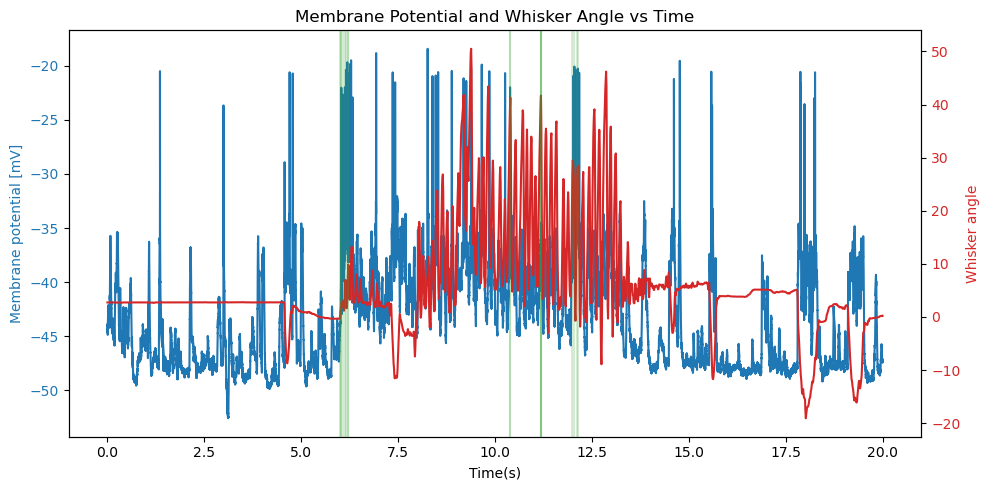

In [8]:
len_sweep_vm = len(data_df['Sweep_MembranePotential'][0])
Fs_whisker_VM = data_df['Sweep_MembranePotential_SamplingRate'][0]
x_VM=np.linspace(0,len_sweep_vm*1/Fs_whisker_VM,len_sweep_vm)
len_sweep_WP = len(data_df['Sweep_WhiskerAngle'][0])
Fs_whisker_angle = data_df['Sweep_WhiskerAngle_SamplingRate'][0]
x_WP=np.linspace(0,len_sweep_WP*1/Fs_whisker_angle,len_sweep_WP)

fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:blue'
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Membrane potential [mV]", color=color)
ax1.plot(x_VM,data_df['Sweep_MembranePotential'][0]*1000, color=color) #[mV]
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2=ax1.twinx()
ax2.set_ylabel("Whisker angle", color=color)
ax2.plot(x_WP,data_df['Sweep_WhiskerAngle'][0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][0][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][0][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][1][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][1][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][2][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][2][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][3][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][3][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][4][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][4][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][6][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][6][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][1], color=color, alpha=0.2)

plt.title('Membrane Potential and Whisker Angle vs Time')
fig.tight_layout()
plt.show()


In [93]:
a = data_df['Sweep_ActiveContactTimes'][1]

b = []
for i in range (len(a)-1):
    if i == 0:
        b.append(a[i, :])
    elif a[i+1][0]-b[-1][1]>0.2:
        b.append(a[i+1,:])
print(b)
print(a)

#c=[sub_array.tolist() for sub_array in b]
c= np.vstack(b)
print(c)


[array([6.793, 6.859]), array([7.113, 7.189]), array([7.511, 7.583]), array([7.817, 7.857]), array([8.131, 8.189]), array([8.521, 8.577]), array([8.795, 8.831]), array([9.171, 9.225]), array([9.459, 9.481]), array([9.715, 9.771]), array([10.575, 10.653]), array([12.147, 12.179]), array([12.489, 12.513])]
[[ 6.793  6.859]
 [ 6.915  6.955]
 [ 6.999  7.075]
 [ 7.113  7.189]
 [ 7.225  7.347]
 [ 7.387  7.461]
 [ 7.511  7.583]
 [ 7.647  7.749]
 [ 7.817  7.857]
 [ 7.953  7.967]
 [ 8.047  8.069]
 [ 8.131  8.189]
 [ 8.263  8.315]
 [ 8.385  8.449]
 [ 8.521  8.577]
 [ 8.657  8.705]
 [ 8.795  8.831]
 [ 8.915  8.959]
 [ 9.015  9.097]
 [ 9.171  9.225]
 [ 9.305  9.359]
 [ 9.459  9.481]
 [ 9.571  9.633]
 [ 9.715  9.771]
 [ 9.825  9.865]
 [ 9.959 10.007]
 [10.575 10.653]
 [10.709 10.759]
 [12.147 12.179]
 [12.273 12.293]
 [12.489 12.513]]
[[ 6.793  6.859]
 [ 7.113  7.189]
 [ 7.511  7.583]
 [ 7.817  7.857]
 [ 8.131  8.189]
 [ 8.521  8.577]
 [ 8.795  8.831]
 [ 9.171  9.225]
 [ 9.459  9.481]
 [ 9.715  9.7

Text(0.5, 1.0, 'Membrane Potential and Whisker Angle vs Time (10s-12.5s)')

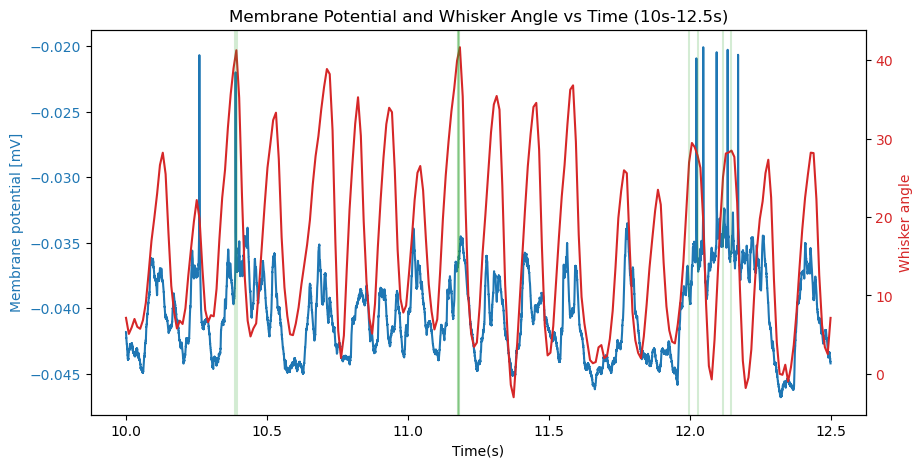

In [9]:
len_WP1= len(data_df['Sweep_WhiskerAngle'][0][1000:1250])
x_WP1=np.linspace(10,12.5,len_WP1)
y_WP1=data_df['Sweep_WhiskerAngle'][0][1000:1250]
len_VM1= len(data_df['Sweep_MembranePotential'][0][200000:250000])
x_VM1=np.linspace(10,12.5,len_VM1)
y_VM1=data_df['Sweep_MembranePotential'][0][200000:250000]


fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:blue'
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Membrane potential [mV]", color=color)
ax1.plot(x_VM1,y_VM1, color=color) #[mV]
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2=ax1.twinx()
ax2.set_ylabel("Whisker angle", color=color)
ax2.plot(x_WP1,y_WP1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

color='tab:green'
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][4][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][4][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][6][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][6][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][1], color=color, alpha=0.2)

plt.title('Membrane Potential and Whisker Angle vs Time (10s-12.5s)')

In [17]:
whisker_angle_0 = data_df['Sweep_WhiskerAngle'][0][0] #whisker angle at the beginning
print(whisker_angle_0)

2.740000000000009


In [18]:
membrane_potential_0 = data_df['Sweep_MembranePotential'][0][0]
print(membrane_potential_0)

-0.044009375


Text(0.5, 1.0, 'Membrane Potential and Whisker Angle vs Time zoomed for one active touch')

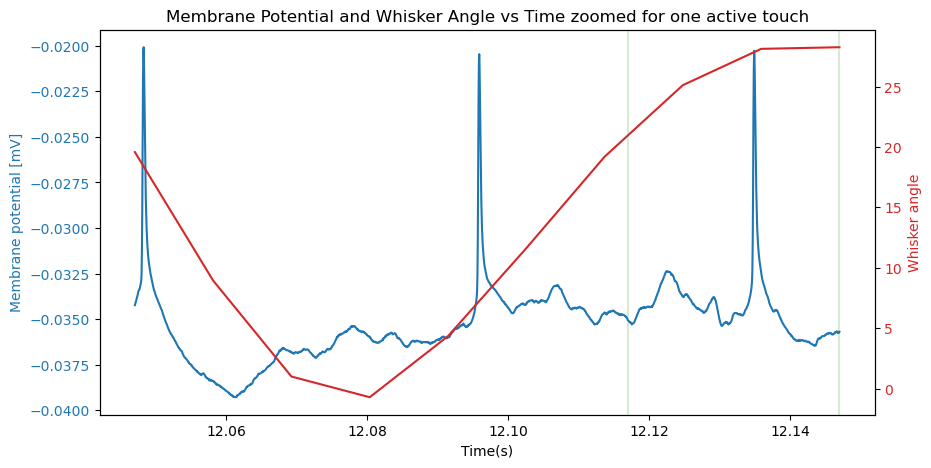

In [12]:
ActiveContactTimes_7_pre= int((data_df['Sweep_ActiveContactTimes'][0][7][1]-0.1)*20000)
ActiveContactTimes_7_post= int((data_df['Sweep_ActiveContactTimes'][0][7][1])*20000)
membrane_potential_AT7 = data_df['Sweep_MembranePotential'][0][ActiveContactTimes_7_pre:ActiveContactTimes_7_post]
len_VM_AT7= len(membrane_potential_AT7)
x_VM_AT7=np.linspace(data_df['Sweep_ActiveContactTimes'][0][7][1]-0.1,data_df['Sweep_ActiveContactTimes'][0][7][1],len_VM_AT7)
y_VM_AT7 = membrane_potential_AT7
ACT_WP_7_pre= int((data_df['Sweep_ActiveContactTimes'][0][7][1]-0.1)*100)
ACT_WP_7_post= int((data_df['Sweep_ActiveContactTimes'][0][7][1])*100)
len_WP_AT7= len(data_df['Sweep_WhiskerAngle'][0][ACT_WP_7_pre:ACT_WP_7_post])
x_WP_AT7=np.linspace(data_df['Sweep_ActiveContactTimes'][0][7][1]-0.1,data_df['Sweep_ActiveContactTimes'][0][7][1],len_WP_AT7)
y_WP_AT7=data_df['Sweep_WhiskerAngle'][0][ACT_WP_7_pre:ACT_WP_7_post]
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:blue'
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Membrane potential [mV]", color=color)
ax1.plot(x_VM_AT7,y_VM_AT7, color=color) #[mV]
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2=ax1.twinx()
ax2.set_ylabel("Whisker angle", color=color)
ax2.plot(x_WP_AT7,y_WP_AT7, color=color)
ax2.tick_params(axis='y', labelcolor=color)

color='tab:green'
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][1], color=color, alpha=0.2)

plt.title('Membrane Potential and Whisker Angle vs Time zoomed for one active touch')

In [25]:
max_WP = max(y_WP_AT7)
min_WP = min(y_WP_AT7)
max_VM = max(y_VM_AT7)
min_VM = min(y_VM_AT7)
print(max_WP)
print(min_WP)
print(max_VM)
print(min_VM)


28.25142229673699
-0.7153919396606057
-0.020078125
-0.039290625


In [43]:
print(data_df['Sweep_ActiveContactTimes'][0][7][1]-0.05)
print(data_df['Sweep_ActiveContactTimes'][0][7][1])


12.097
12.147


In [28]:
#Sweep_ActiveContactTimes

In [29]:
data_df['Sweep_WhiskerAngle_SamplingRate']

0      100.0
1      100.0
2      100.0
3      100.0
4      100.0
       ...  
826    100.0
827    100.0
828    100.0
829    100.0
830    100.0
Name: Sweep_WhiskerAngle_SamplingRate, Length: 831, dtype: float64

In [30]:
print(data_df.columns)

Index(['Cell_APThreshold_Slope', 'Cell_Anatomy', 'Cell_Counter', 'Cell_Depth',
       'Cell_ID', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type',
       'Cell_tdTomatoExpressing', 'Mouse_DateOfBirth', 'Mouse_Genotype',
       'Mouse_Name', 'Mouse_Sex', 'Sweep_ActiveContactTimes', 'Sweep_Counter',
       'Sweep_MembranePotential', 'Sweep_MembranePotential_SamplingRate',
       'Sweep_PassiveContactTimes', 'Sweep_QuietTimes', 'Sweep_StartTime',
       'Sweep_Type', 'Sweep_WhiskerAngle', 'Sweep_WhiskerAngle_SamplingRate',
       'Sweep_WhiskingTimes'],
      dtype='object')


In [31]:
data_df['Sweep_MembranePotential_SamplingRate']

0      20000.0
1      20000.0
2      20000.0
3      20000.0
4      20000.0
        ...   
826    20000.0
827    20000.0
828    20000.0
829    20000.0
830    20000.0
Name: Sweep_MembranePotential_SamplingRate, Length: 831, dtype: float64

In [32]:
data_df['Sweep_WhiskerAngle']

0      [2.740000000000009, 2.740000000000009, 2.74000...
1      [2.680000000000007, 2.680000000000007, 2.68000...
2      [1.4958937492820894, 1.5019819900587095, 1.509...
3      [2.467493802679826, 2.459711310964792, 2.46562...
4      [2.4399999999999977, 2.4399999999999977, 2.440...
                             ...                        
826    [-139.2381, -139.2381, -139.2381, -139.2381, -...
827    [-144.9738, -144.9738, -144.9738, -145.6111, -...
828    [-150.0723, -150.0723, -150.0723, -150.0723, -...
829    [-144.9738, -144.9738, -144.9738, -145.6111, -...
830    [-142.4246, -142.4246, -142.4246, -142.4246, -...
Name: Sweep_WhiskerAngle, Length: 831, dtype: object

In [12]:
display(data_df_subset)

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]"
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2.0,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006..."
3,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,4.0,"[-0.04655625, -0.0465875, -0.046575, -0.046596...",20000.0,nan,"[[0.002, 2.764], [12.03, 14.464], [14.814, 15....",2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1..."
4,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,5.0,"[-0.047296875, -0.047284375, -0.047265625, -0....",20000.0,"[[4.411000000000001, 4.4809999999999945], [5.2...","[[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...",2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2..."
5,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,6.0,"[-0.040259375, -0.040284375, -0.040284375, -0....",20000.0,"[[1.992999999999995, 2.272999999999996], [9.82...","[[0.002, 1.99], [2.274, 3.632], [3.796, 4.904]...",2005.0,active touch,"[1.789999999999992, 1.789999999999992, 1.78999...",100.0,"[[4.954, 5.07], [6.216, 9.328], [9.832, 10.07]..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,15.0,L4,2.0,460.0,TK539_2,L4,C2,EXC,True,2017.0,...,1.0,"[-0.06493165939018428, -0.06495139106057463, -...",20000.0,nan,"[[0.002, 6.85], [7.686, 9.5], [13.596, 19.598]...",2017.0,active touch,"[194.3828, 194.3828, 194.0966, 193.8104, 193.8...",100.0,"[[6.852, 7.618], [9.502, 13.594], [19.614, 19...."
621,15.0,L4,2.0,460.0,TK539_2,L4,C2,EXC,True,2017.0,...,2.0,"[-0.059617267734583854, -0.05954162980331142, ...",20000.0,nan,"[[0.002, 2.168], [2.276, 10.734], [11.176, 43....",2017.0,active touch,"[191.8068, 191.8068, 191.8068, 191.8068, 191.8...",100.0,"[[10.75, 11.144], [43.158, 43.446], [53.204, 5..."
623,10.0,L4,1.0,432.0,TK545_1,L4,C2,EXC,True,2016.0,...,1.0,"[-0.05053415164553155, -0.05047824550450753, -...",20000.0,nan,"[[0.002, 0.188], [1.938, 7.156], [15.986, 16.0]]",2017.0,active touch,"[178.9267, 177.2093, 176.6369, 177.4955, 177.4...",100.0,"[[0.878, 1.696], [7.158, 15.982]]"
625,25.0,L4,2.0,390.0,TK545_2,L4,C2,EXC,True,2016.0,...,1.0,"[-0.07429106450681139, -0.07431737349338013, -...",20000.0,nan,"[[0.002, 3.026], [3.966, 5.5], [5.528, 6.81], ...",2017.0,active touch,"[181.2165, 181.2165, 180.9302, 180.9302, 180.9...",100.0,"[[3.066, 3.726], [16.632, 17.39], [18.592, 18...."


In [14]:
data_df_subset.head(10)

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]"
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2.0,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006..."
3,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,4.0,"[-0.04655625, -0.0465875, -0.046575, -0.046596...",20000.0,nan,"[[0.002, 2.764], [12.03, 14.464], [14.814, 15....",2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1..."
4,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,5.0,"[-0.047296875, -0.047284375, -0.047265625, -0....",20000.0,"[[4.411000000000001, 4.4809999999999945], [5.2...","[[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...",2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2..."
5,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,6.0,"[-0.040259375, -0.040284375, -0.040284375, -0....",20000.0,"[[1.992999999999995, 2.272999999999996], [9.82...","[[0.002, 1.99], [2.274, 3.632], [3.796, 4.904]...",2005.0,active touch,"[1.789999999999992, 1.789999999999992, 1.78999...",100.0,"[[4.954, 5.07], [6.216, 9.328], [9.832, 10.07]..."
10,10.0,L5,1.0,550.0,SC903_1,L5,C2,EXC,False,NaN,...,1.0,"[-0.050484375, -0.050425, -0.05049375, -0.0505...",20000.0,"[6.461, 6.775]","[[0.002, 0.01], [6.226, 6.852], [9.71, 10.946]...",2005.0,active touch,"[11.55361080427187, 5.866629462925175, 0.06826...",100.0,"[[0.01, 5.386], [6.858, 9.516], [10.952, 11.68..."
11,10.0,L2/3,1.0,244.0,SC904_1,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.0473, -0.047303125, -0.0473, -0.047371875,...",20000.0,nan,"[[0.002, 0.01], [3.934, 4.696], [5.63, 6.686],...",2005.0,active touch,"[2.5770158109846193, 4.110153818102248, 8.0886...",100.0,"[[0.01, 3.928], [6.784, 10.392], [11.252, 11.4..."
12,10.0,L2/3,1.0,244.0,SC904_1,L2/3,C2,EXC,False,NaN,...,2.0,"[-0.04565, -0.045693750000000005, -0.045665625...",20000.0,"[[4.123000000000001, 4.6469999999999985], [13....","[[0.002, 0.012], [4.078, 4.614], [8.678, 9.206...",2005.0,active touch,"[15.024251146918687, 15.620325994263823, 13.29...",100.0,"[[0.032, 2.118], [3.152, 3.774], [5.034, 7.12]..."
14,10.0,L2/3,1.0,244.0,SC904_1,L2/3,C2,EXC,False,NaN,...,4.0,"[-0.041415625, -0.041371874999999995, -0.04137...",20000.0,"[[5.010999999999996, 5.489000000000004], [15.2...","[[0.002, 0.676], [2.362, 3.22], [9.5, 10.026],...",2005.0,active touch,"[-1.853490035168079, -1.9445967619359976, -1.8...",100.0,"[[3.222, 3.428], [3.956, 4.314], [5.484, 8.718..."
15,10.0,L2/3,1.0,244.0,SC904_1,L2/3,C2,EXC,False,NaN,...,5.0,"[-0.0472, -0.04725, -0.04715, -0.047246875, -0...",20000.0,"[[16.826999999999998, 17.143], [18.08700000000...","[[0.002, 0.01], [1.534, 2.38], [2.446, 3.618],...",2005.0,active touch,"[-4.445863318123145, -1.9268068066624835, 2.10...",100.0,"[[0.01, 1.53], [3.622, 4.37], [5.784, 6.046], ..."


In [48]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def VmVsWhiskerAngle (cell_id):
    # Prepare a colormap
    colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
    color_index = 0

    #cell_id = 'SC901_1'
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell_id]
    plt.figure(figsize=(10, 6))
    trial_list = cell_df.Sweep_Counter

    for trial in trial_list:
        trial_data = cell_df[cell_df.Sweep_Counter == trial]

        # Extract necessary data for the trial
        sr_vm = trial_data['Sweep_MembranePotential_SamplingRate'].values[0]
        membrane_potential = trial_data['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = trial_data['Cell_APThreshold_Slope'].values[0]
        whisker_angle = trial_data['Sweep_WhiskerAngle'].values[0]
        active_touch_times = trial_data['Sweep_ActiveContactTimes'].values[0]
        sr_wp = trial_data['Sweep_WhiskerAngle_SamplingRate'].values[0]


        good_active_touch_times = []
        for i in range (len(active_touch_times)-1):
            if i == 0:
                good_active_touch_times.append(active_touch_times[i, :])
            elif active_touch_times[i+1][0]-good_active_touch_times[-1][1]>0.2:
                good_active_touch_times.append(active_touch_times[i+1,:])

        good_active_touch_times = np.vstack(good_active_touch_times)

        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        ap_peak_times = ap_params[:, 2]
        ap_thresh_times = ap_params[:, 0]   
        vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

        time_vm = np.arange(len(vm_subthreshold)) / sr_vm
        time_whisker = np.arange(len(whisker_angle)) / sr_wp

        # Initialize a list to store min and max Vm for each active touch interval
        min_max_vm_values = []
        delta_vm = []

        # Initialize a list to store min and max WP for each active touch interval
        min_max_wp_values = []
        delta_wp = []

        for start, end in good_active_touch_times:
            # Convert the start and end time of the active touch to indices
            start_index_VM = np.searchsorted(time_vm, start)
            end_index_VM = np.searchsorted(time_vm, end+0.05)
            start_index_WP = np.searchsorted(time_whisker, start-0.05)
            end_index_WP = np.searchsorted(time_whisker, end)

            # Extract the Vm segment for the current interval
            vm_segment = vm_subthreshold[start_index_VM:end_index_VM]
            # Extract the Vm segment for the current interval
            wp_segment = whisker_angle[start_index_WP:end_index_WP]

            # Calculate the minimum and maximum Vm for the segment
            min_vm = np.min(vm_segment)
            max_vm = np.max(vm_segment)
            delta_vm.append(max_vm-min_vm)


            # Calculate the minimum and maximum Vm for the segment
            min_wp = np.min(wp_segment)
            max_wp = np.max(wp_segment)
            delta_wp.append(max_wp-min_wp)

            # Store the results
            min_max_wp_values.append((min_wp, max_wp))

            # min_max_vm_values now contains tuples of (min Vm, max Vm) for each active touch interval

        plt.scatter(delta_wp, delta_vm, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')
        color_index += 1

    from scipy.stats import pearsonr
    correlation_coefficient, p_value = pearsonr(delta_wp, delta_vm)
    #plt.title(f'Cell {cell_id}\nPearson\'s correlation coefficient (r): {correlation_coefficient:.2f}, p-value: {p_value:.4f}')


    # Add labels, title, and legend
    plt.ylabel('Vm Amplitude (V)')
    plt.xlabel('Whisker Angle Amplitude (degrees)')
    plt.title(f'Correlation Between Vm Amplitude and Whisker Angle Amplitude Across Trials \nPearson\'s correlation coefficient (r): {correlation_coefficient:.2f}, p-value: {p_value:.4f}' )
    plt.legend()

    # Show plot
    plt.show()


In [49]:
def VmVsWhiskerVelocity(cell_id):
    # Prepare a colormap
    colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
    color_index = 0

    cell_df = data_df_subset[data_df_subset.Cell_ID==cell_id]
    plt.figure(figsize=(10, 6))
    trial_list = cell_df.Sweep_Counter

    for trial in trial_list:
        trial_data = cell_df[cell_df.Sweep_Counter == trial]

        # Extract necessary data for the trial
        sr_vm = trial_data['Sweep_MembranePotential_SamplingRate'].values[0]
        membrane_potential = trial_data['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = trial_data['Cell_APThreshold_Slope'].values[0]
        whisker_angle = trial_data['Sweep_WhiskerAngle'].values[0]
        active_touch_times = trial_data['Sweep_ActiveContactTimes'].values[0]
        sr_wp = trial_data['Sweep_WhiskerAngle_SamplingRate'].values[0]


        good_active_touch_times = []
        for i in range (len(active_touch_times)-1):
            if i == 0:
                good_active_touch_times.append(active_touch_times[i, :])
            elif active_touch_times[i+1][0]-good_active_touch_times[-1][1]>0.2:
                good_active_touch_times.append(active_touch_times[i+1,:])

        good_active_touch_times = np.vstack(good_active_touch_times)

        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        ap_peak_times = ap_params[:, 2]
        ap_thresh_times = ap_params[:, 0]   
        vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

        time_vm = np.arange(len(vm_subthreshold)) / sr_vm
        time_whisker = np.arange(len(whisker_angle)) / sr_wp

        # Initialize a list to store min and max Vm for each active touch interval
        min_max_vm_values = []
        delta_vm = []

        # Initialize a list to store min and max WP for each active touch interval
        min_max_wp_values = []
        delta_wp = []
        velocity_wp = []

        for start, end in good_active_touch_times:
            # Convert the start and end time of the active touch to indices
            start_index_VM = np.searchsorted(time_vm, start)
            end_index_VM = np.searchsorted(time_vm, end+0.05)
            start_index_WP = np.searchsorted(time_whisker, start-0.05)
            end_index_WP = np.searchsorted(time_whisker, end)

            # Extract the Vm segment for the current interval
            vm_segment = vm_subthreshold[start_index_VM:end_index_VM]
            # Extract the Vm segment for the current interval
            wp_segment = whisker_angle[start_index_WP:end_index_WP]

            # Calculate the minimum and maximum Vm for the segment
            min_vm = np.min(vm_segment)
            max_vm = np.max(vm_segment)
            delta_vm.append(max_vm-min_vm)


            # Calculate the minimum and maximum Vm for the segment
            min_wp = np.min(wp_segment)
            max_wp = np.max(wp_segment)
            delta_wp.append(max_wp-min_wp)
            velocity_wp.append((whisker_angle[end_index_WP]-whisker_angle[start_index_WP])/0.05)

            # Store the results
            min_max_wp_values.append((min_wp, max_wp))

            # min_max_vm_values now contains tuples of (min Vm, max Vm) for each active touch interval

        plt.scatter(velocity_wp, delta_vm, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')
        color_index += 1

    from scipy.stats import pearsonr
    correlation_coefficient, p_value = pearsonr(velocity_wp, delta_vm)

    # Add labels, title, and legend
    plt.ylabel('Vm Amplitude (V)')
    plt.xlabel('Velocity Whisker Angle')
    plt.title(f'Correlation Between Vm Amplitude and Whisker Angle Amplitude Across Trials \nPearson\'s correlation coefficient (r): {correlation_coefficient:.2f}, p-value: {p_value:.4f}')
    plt.legend()

    # Show plot
    plt.show()

In [50]:
def deltaVmVsICI(cell_id):

    # Prepare a colormap
    colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
    color_index = 0

    cell_df = data_df_subset[data_df_subset.Cell_ID==cell_id]
    plt.figure(figsize=(10, 6))
    trial_list = cell_df.Sweep_Counter

    for trial in trial_list:
        trial_data = cell_df[cell_df.Sweep_Counter == trial]

        # Extract necessary data for the trial
        sr_vm = trial_data['Sweep_MembranePotential_SamplingRate'].values[0]
        membrane_potential = trial_data['Sweep_MembranePotential'].values[0]
        #ap_vm_deriv_thresh = trial_data['Cell_APThreshold_Slope'].values[0]
        whisker_angle = trial_data['Sweep_WhiskerAngle'].values[0]
        active_touch_times = trial_data['Sweep_ActiveContactTimes'].values[0]
        sr_wp = trial_data['Sweep_WhiskerAngle_SamplingRate'].values[0]


        active_touch_times_diff = []
        diff_vm = []
        for i in range (len(active_touch_times)-1):
            if active_touch_times[i+1][0]-active_touch_times[i][1]<0.5: 
                active_touch_times_diff.append(active_touch_times[i+1][0]-active_touch_times[i][1])
                test=membrane_potential[int(active_touch_times[i][1]*20000):int(active_touch_times[i+1][0]*20000)]
                diff_vm.append(max(test)-min(test))
        active_touch_times_diff = np.vstack(active_touch_times_diff)

        plt.scatter(active_touch_times_diff, diff_vm, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')
        color_index += 1


    # Add labels, title, and legend
    plt.ylabel('diff_vm')
    plt.xlabel('ici')
    plt.title(f'Correlation Between diff_vm and ici Across Trials')
    plt.legend()

    # Show plot
    plt.show()

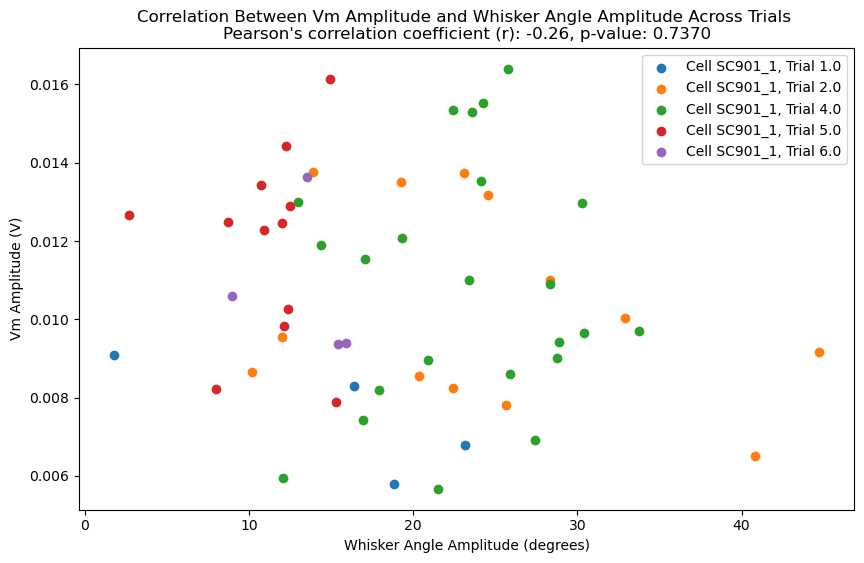

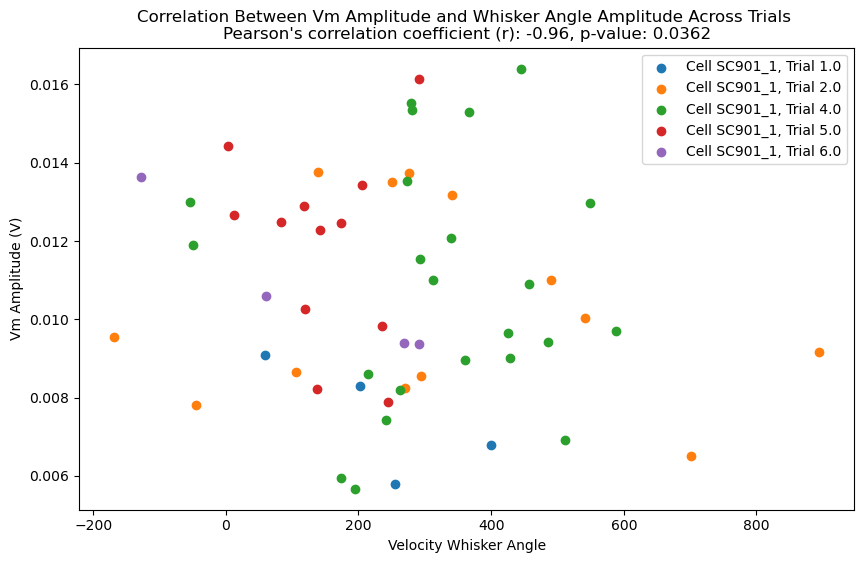

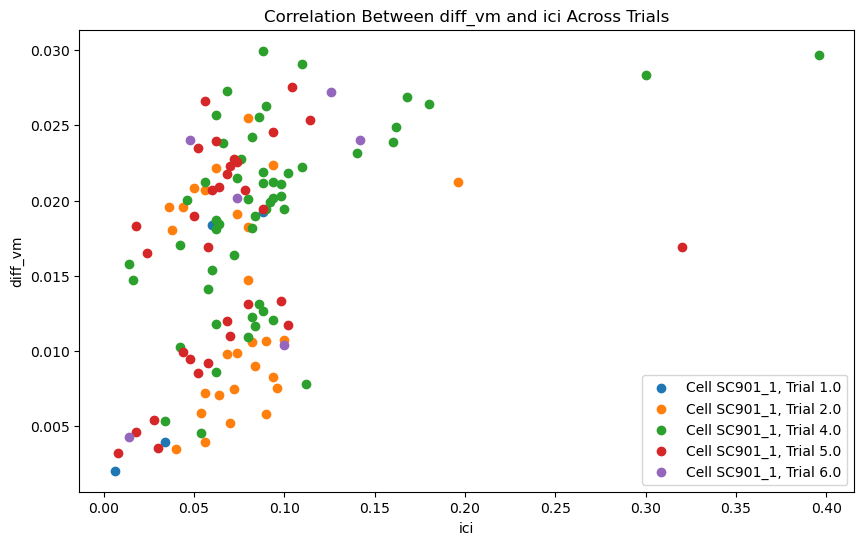

In [51]:
VmVsWhiskerAngle('SC901_1')
VmVsWhiskerVelocity('SC901_1')
deltaVmVsICI('SC901_1')

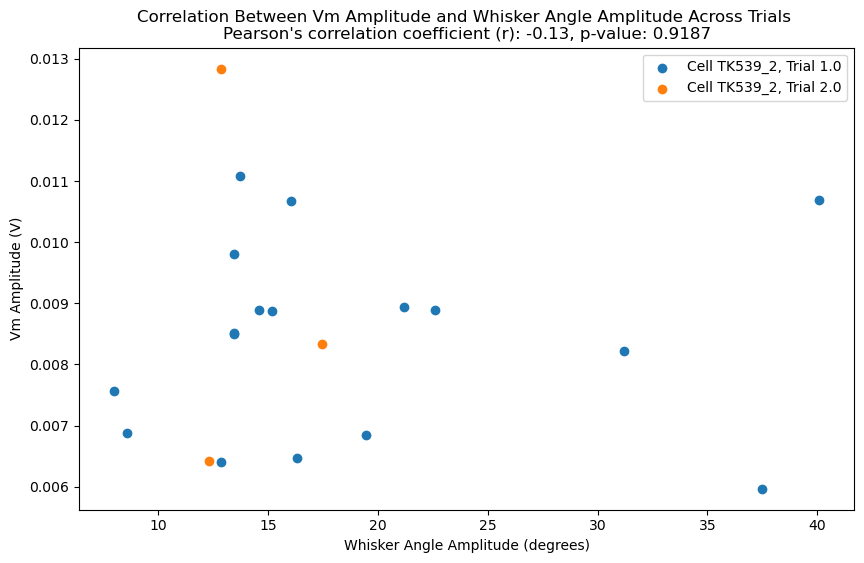

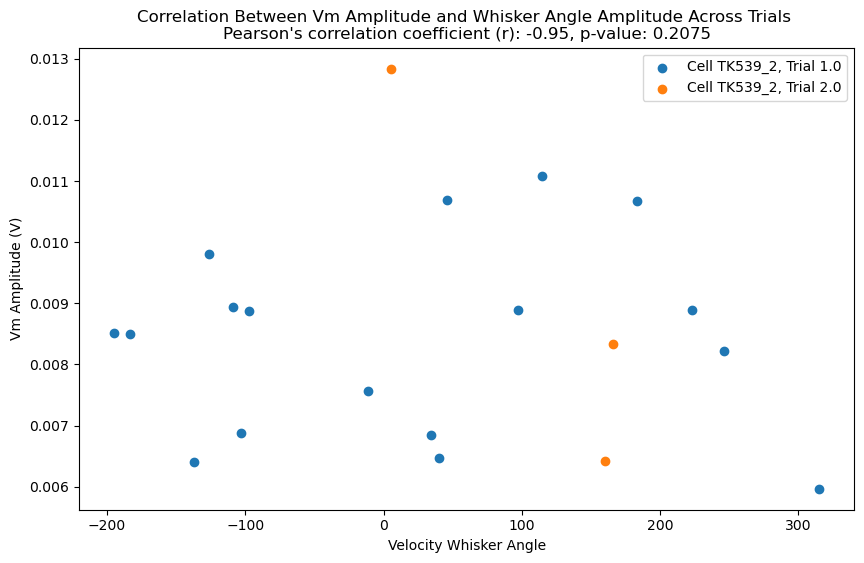

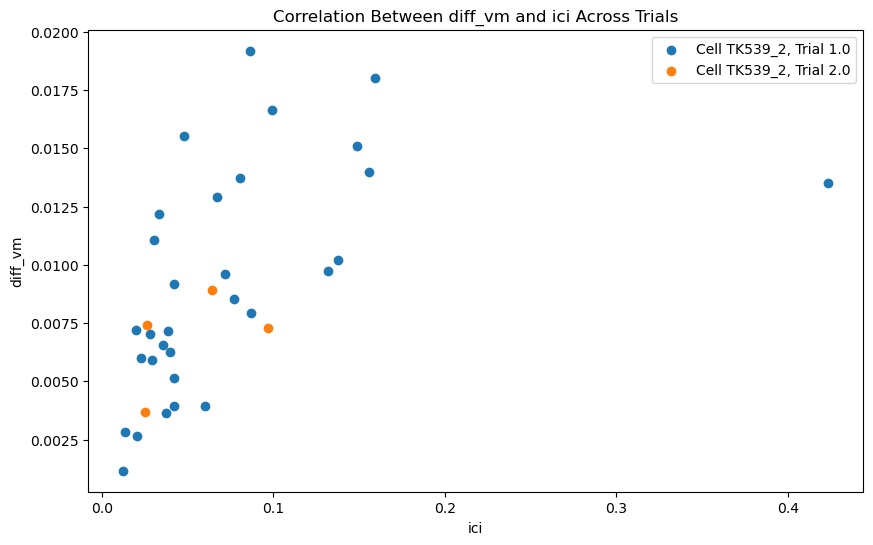

In [52]:
VmVsWhiskerAngle('TK539_2')
VmVsWhiskerVelocity('TK539_2')
deltaVmVsICI('TK539_2')

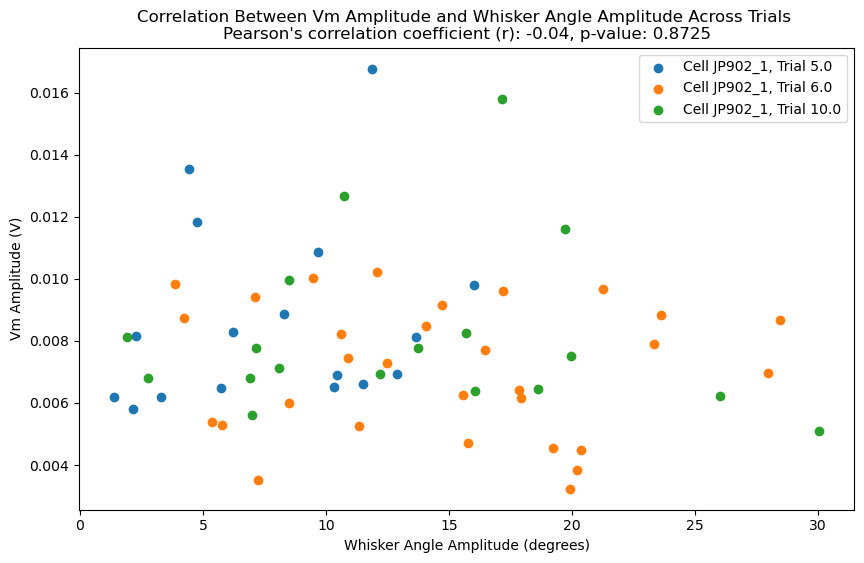

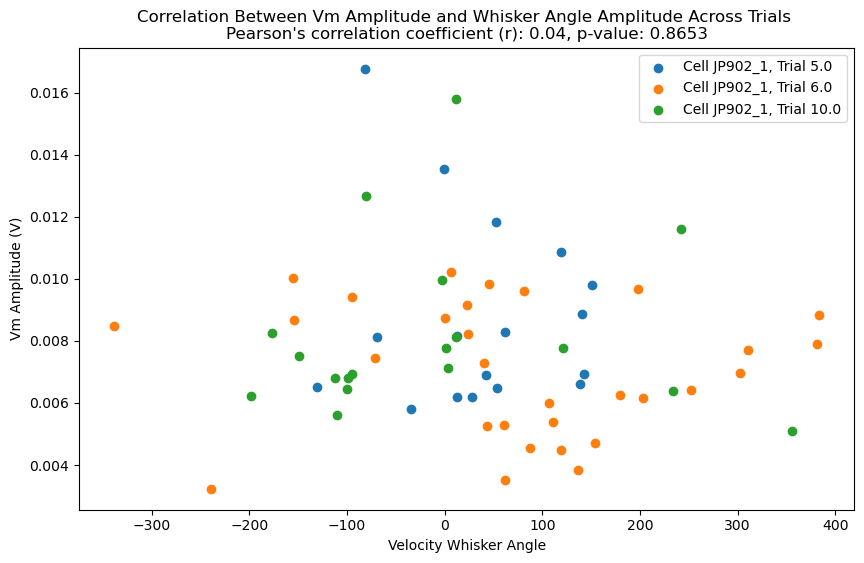

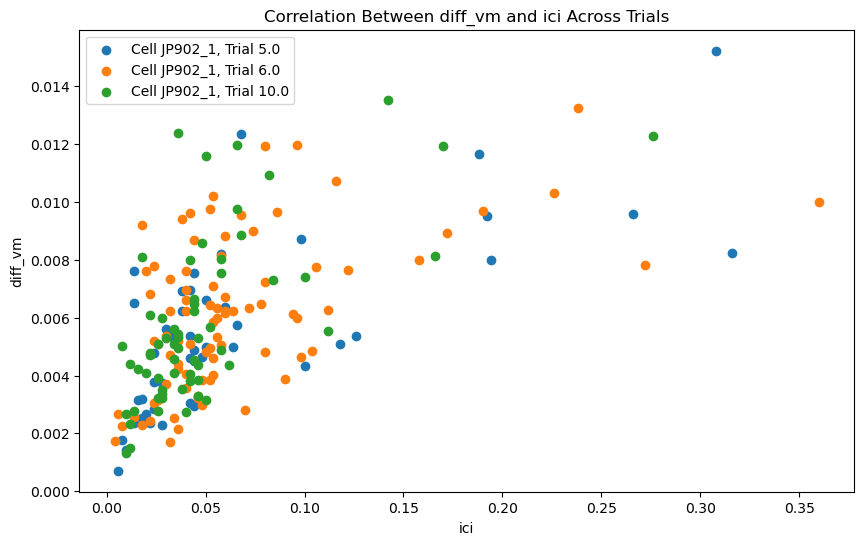

In [53]:
VmVsWhiskerAngle('JP902_1')
VmVsWhiskerVelocity('JP902_1')
deltaVmVsICI('JP902_1')

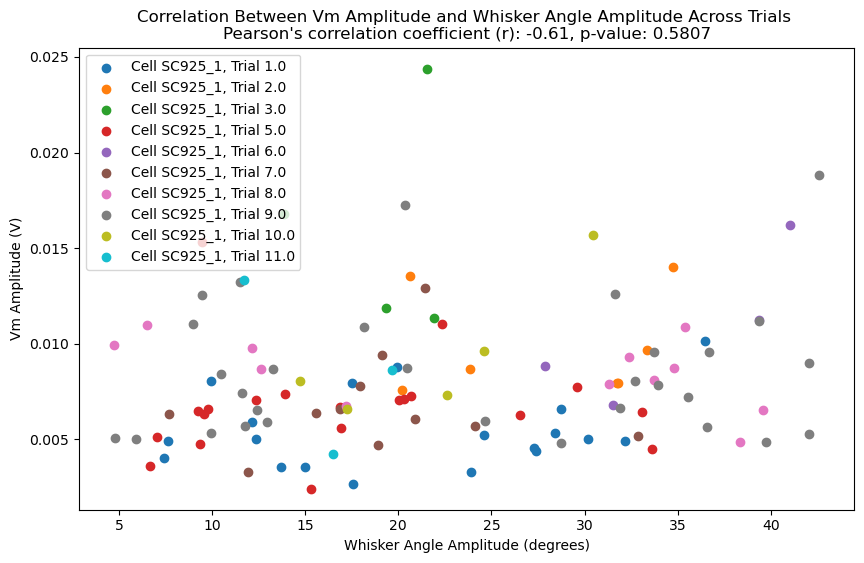

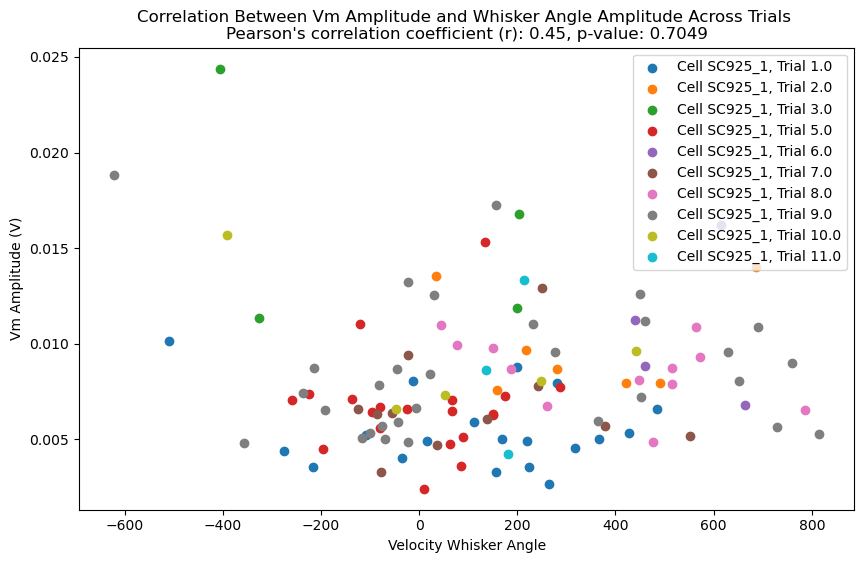

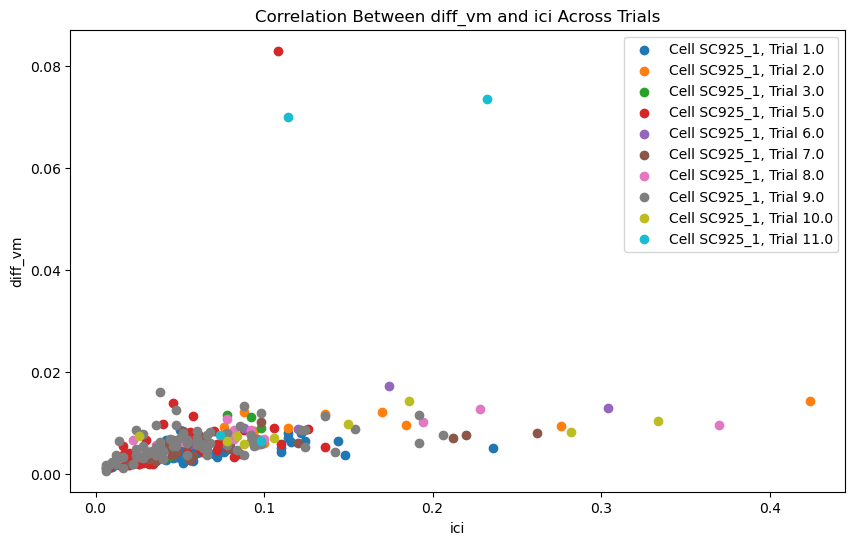

In [54]:
VmVsWhiskerAngle('SC925_1')
VmVsWhiskerVelocity('SC925_1')
deltaVmVsICI('SC925_1')

In [33]:
whisker = data_df['Sweep_WhiskerAngle'][100]

In [34]:
#angle at the beginning

In [35]:
#plt.plot(np.arange[1,2001],whisker)

In [36]:
#le temps=longueur du vector/sampling rate

In [38]:
good_event_times = []
min_iti=0.2

if type(event_times[0]) == np.float64:
    good_event_times.append(event_times)
else:
    for i in np.arange(len(event_times)):
        if i == len(event_times)-1:
            good_event_times.append(event_times[i])
        elif event_times[i+1][0] - event_times[i][1] > min_iti:
            good_event_times.append(event_times[i])

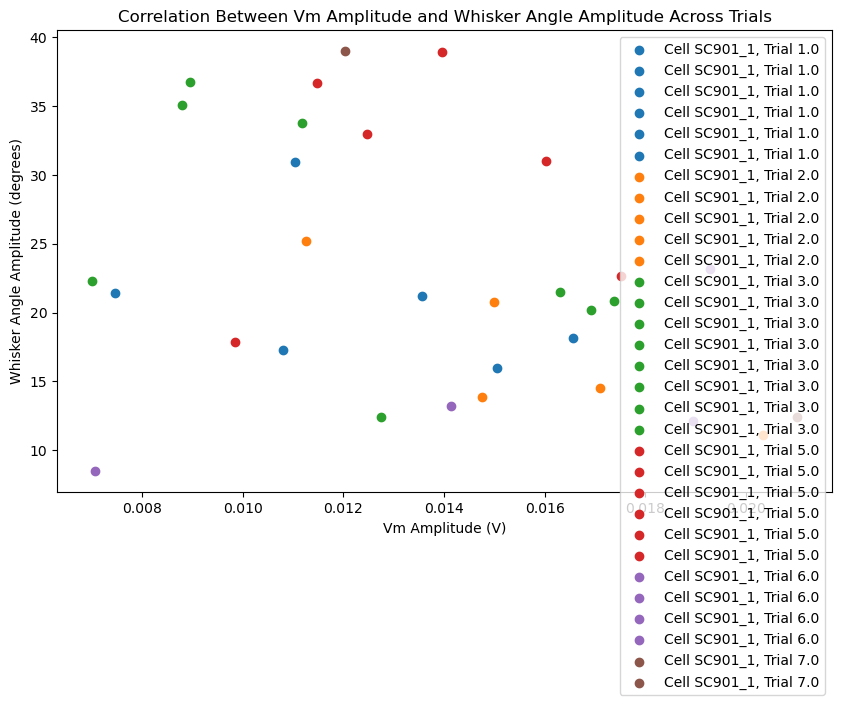

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
cell_id = 'SC901_1'
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content
cell_data = data_df_subset.iloc[35]
cell_df = data_df_subset[data_df_subset.Cell_ID==cell_data['Cell_ID']]

# Prepare a colormap
colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
color_index = 0

plt.figure(figsize=(10, 6))

trial_list = cell_df.Sweep_Counter.unique()
    # Iterate over each trial
for trial in trial_list:
    trial_data = cell_df[cell_df.Sweep_Counter == trial]

        # Extract necessary data for the trial
    sr_vm = trial_data['Sweep_MembranePotential_SamplingRate'].values[0]
    membrane_potential = trial_data['Sweep_MembranePotential'].values[0]
    ap_vm_deriv_thresh = trial_data['Cell_APThreshold_Slope'].values[0]
    whisker_angle = trial_data['Sweep_WhiskerAngle'].values[0]
    active_touch_times = trial_data['Sweep_ActiveContactTimes'].values[0]

        # Detect action potentials and process membrane potential
    ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
    ap_peak_times = ap_params[:, 2]
    ap_thresh_times = ap_params[:, 0]
    vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

        # Time arrays for indexing
    time_vm = np.arange(len(vm_subthreshold)) / sr_vm
    time_whisker = np.arange(len(whisker_angle)) / trial_data['Sweep_WhiskerAngle_SamplingRate'].values[0]

        # Filter active touch times
    good_event_times = []
    if type(active_touch_times[0]) == np.float64:
        good_event_times.append(active_touch_times)
    else:
        for i in np.arange(len(active_touch_times)):
            if i == len(active_touch_times)-1 or active_touch_times[i+1][0] - active_touch_times[i][1] > 0.2:
                good_event_times.append(active_touch_times[i])

        # Calculate min-max for each interval
    for start, end in good_event_times:
            # For membrane potential
        start_index_vm = np.searchsorted(time_vm, start)
        end_index_vm = np.searchsorted(time_vm, end+0.05)
        vm_segment = vm_subthreshold[start_index_vm:end_index_vm]
        vm_amplitude = np.max(vm_segment) - np.min(vm_segment)

            # For whisker angle
        start_index_whisker = np.searchsorted(time_whisker, start-0.05)
        end_index_whisker = np.searchsorted(time_whisker, end)
        whisker_segment = whisker_angle[start_index_whisker:end_index_whisker]
        angle_amplitude = np.max(whisker_segment) - np.min(whisker_segment)

            # Scatter plot for each interval
        plt.scatter(vm_amplitude, angle_amplitude, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')

    color_index += 1

# Add labels, title, and legend
plt.xlabel('Vm Amplitude (V)')
plt.ylabel('Whisker Angle Amplitude (degrees)')
plt.title('Correlation Between Vm Amplitude and Whisker Angle Amplitude Across Trials')
plt.legend()

# Show plot
plt.show()

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Filter out only excitatory cells
exc_cells = data_df_subset[data_df_subset['Cell_Type'] == 'EXC']

# Get a list of unique excitatory cell IDs
exc_cell_ids = np.unique(exc_cells['Cell_ID'])

# Prepare a colormap
colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction

# Iterate over each excitatory cell
for cell_id in exc_cell_ids:
    cell_df = exc_cells[exc_cells['Cell_ID'] == cell_id]
    trial_list = cell_df['Sweep_Counter'].unique()

    plt.figure(figsize=(10, 6))
    color_index = 0

    # Iterate over each trial
    for trial in trial_list:
        trial_data = cell_df[cell_df['Sweep_Counter'] == trial]

        # Extract necessary data for the trial
        sr_vm = trial_data['Sweep_MembranePotential_SamplingRate'].values[0]
        membrane_potential = trial_data['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = trial_data['Cell_APThreshold_Slope'].values[0]
        whisker_angle = trial_data['Sweep_WhiskerAngle'].values[0]
        active_touch_times = trial_data['Sweep_ActiveContactTimes'].values[0]

        # Detect action potentials and process membrane potential
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        ap_peak_times = ap_params[:, 2]
        ap_thresh_times = ap_params[:, 0]
        vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

        # Time arrays for indexing
        time_vm = np.arange(len(vm_subthreshold)) / sr_vm
        time_whisker = np.arange(len(whisker_angle)) / trial_data['Sweep_WhiskerAngle_SamplingRate'].values[0]

        # Filter active touch times
        good_event_times = []
        if isinstance(active_touch_times, np.ndarray) and active_touch_times.ndim == 2:
            for i in np.arange(len(active_touch_times)):
                if i == len(active_touch_times) - 1 or active_touch_times[i+1][0] - active_touch_times[i][1] > 0.2:
                    good_event_times.append(active_touch_times[i])
        elif isinstance(active_touch_times, np.ndarray) and active_touch_times.ndim == 1:
            good_event_times.append(active_touch_times)



        for start, end in good_event_times:
            # For membrane potential
            start_index_vm = np.searchsorted(time_vm, start)
            end_index_vm = np.searchsorted(time_vm, end + 0.05)
            vm_segment = vm_subthreshold[start_index_vm:end_index_vm]
            vm_amplitude = np.max(vm_segment) - np.min(vm_segment)


            # For whisker angle velocity
            start_index_whisker = np.searchsorted(time_whisker, start - 0.05)
            end_index_whisker = np.searchsorted(time_whisker, end)
            whisker_segment = whisker_angle[start_index_whisker:end_index_whisker]
            time_segment = time_whisker[start_index_whisker:end_index_whisker]

            # Calculate the velocity (first derivative) of whisker angle
            if len(whisker_segment) > 1:
                whisker_velocity = np.diff(whisker_segment) / np.diff(time_segment)
                avg_whisker_velocity = np.mean(whisker_velocity)  # Average velocity over the interval
            else:
                avg_whisker_velocity = np.nan

            # Scatter plot for each interval
            if not np.isnan(vm_amplitude) and not np.isnan(avg_whisker_velocity):
                plt.scatter(vm_amplitude, avg_whisker_velocity, color=colors[color_index % len(colors)], label=f'Trial {trial}')

        color_index += 1

    # Add labels, title, and legend
    plt.xlabel('Vm Amplitude (V)')
    plt.ylabel('Average Whisker Velocity (angle units/s)')
    plt.title(f'Cell {cell_id}: Correlation Between Vm Amplitude and Average Whisker Velocity Across Trials')
    plt.legend()

    # Show plot
    plt.show()

SyntaxError: invalid non-printable character U+00A0 (1296978862.py, line 88)